In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from PIL import Image
import numpy as np

import matplotlib.pyplot as plt


In [2]:
train_dir = os.path.join('edges2shoes', 'train')

In [3]:
class DatasetFromFolder(Dataset):
    def __init__(self, image_dir, transforms=None):
        self.transforms = transforms
        self.image_dir = image_dir
        self.image_files = [x for x in os.listdir(self.image_dir) if self._is_image(x)]
        
    def _is_image(self, filename):
        return any(filename.endswith(extension) 
                   for extension in ['.jpg', '.jpeg', '.png'])
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.image_dir, self.image_files[idx])).convert('RGB')
        img = np.array(img)
        image_a = img[:, :256, :]
        image_b = img[:, 256:, :]
        
        if self.transforms:
            image_a = self.transforms(image_a)
            image_b = self.transforms(image_b)
            
        return image_a, image_b
    
    

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = DatasetFromFolder(image_dir=train_dir, transforms=transform)

In [5]:
len(dataset)

49825

In [6]:
a, b = dataset[1]

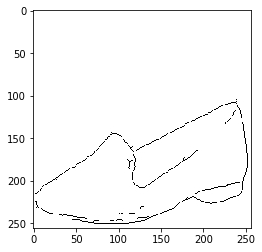

In [7]:
plt.imshow(np.transpose(a, (1,2,0)))

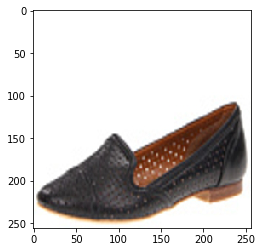

In [8]:
plt.imshow(np.transpose(b, (1,2,0)))

#### Display image side by side

In [48]:
dataloader = DataLoader(dataset, shuffle=True, batch_size=16)

In [55]:
data = iter(dataloader)
X, Y = data.next()

print(X.size())
print(Y.size())

torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])


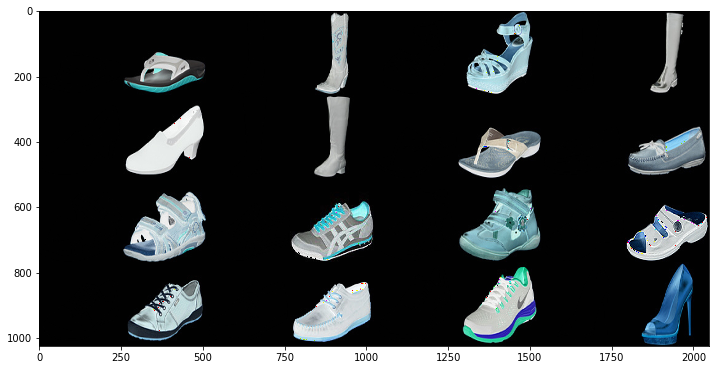

In [70]:
def to_data(x):
    if torch.cuda.is_available():
        x = x.cpu()
    x = x.data.numpy()
    x = ((1 + x) * 255 / (2)).astype(np.uint8)
    return x


def scale(x, feature_range=(-1, 1)):
    """ Scale the input image X in to range
    of feature_range.
    
    This function assumes that the input x is
    already scale from 0-1.
    """
    
    min, max = feature_range
    x = x * (max - min) + min
    return x


def save_sample(iteration, image_X, image_Y, batch_size=16):
    image_X, image_Y = scale(image_X), scale(image_Y)
    
    X, Y = to_data(image_X), to_data(image_Y)
    img = merge_images(X, Y, batch_size)
    img = Image.fromarray((img * 255).astype(np.uint8))
    plt.figure(figsize=(12, 8))
    plt.imshow(img)


def merge_images(sources, targets, batch_size=16):
    _, _, h, w = sources.shape
    row = int(np.sqrt(batch_size))
    merged = np.zeros([3, row*h, row*w*2])
    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
    merged = merged.transpose(1, 2, 0)
    return merged

save_sample(0, X, Y, batch_size=16)

In [76]:
a = scale(X)
b = scale(Y)

In [77]:
print("Min a: ", a.min())
print("Max a: ", a.max())

Min a:  tensor(-1.)
Max a:  tensor(1.)


In [78]:
img_a = scale(a)
img_b = scale(b)

print("Shape a: ", img_a.shape)
print("Shape b: ", img_b.shape)

Shape a:  torch.Size([16, 3, 256, 256])
Shape b:  torch.Size([16, 3, 256, 256])


In [107]:
n, c, h, w = img_a.shape

print(n, c, h, w)

16 3 256 256


In [81]:
row = int(np.sqrt(16))
print(row)

4


In [100]:
merges = np.zeros([3, h * row, w * 2 * row])
print(merges.shape)

(3, 1024, 2048)


In [96]:
np.transpose(img_a, (0, 2,3,1)).shape

torch.Size([16, 256, 256, 3])

In [127]:
data = list(zip(img_a[0], img_b[0]))[0]

(tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]), tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

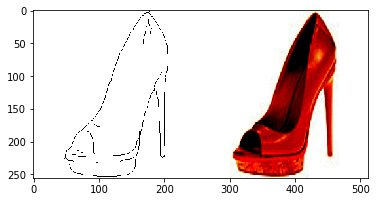

In [132]:
for idx, (s, t) in enumerate(zip(img_a, img_b)):
    i = idx // row
    j = idx % row
    
    img = np.hstack((np.transpose(s, (1,2,0)),
                    np.transpose(t, (1,2,0))))
    
    plt.imshow(img)
    
    

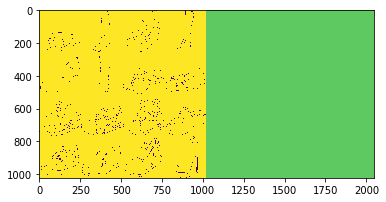

In [114]:
plt.imshow(merges[0])